In [1]:
#loading in respective imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
sns.set(style="darkgrid")

In [2]:
#reading in parameter settings and creating dict for data viz


pdSingleParamDataset = pd.read_excel(f"../dataInputs/inputSheet.xlsx",sheet_name='systemSettings')
pdEyParamDataset = pd.read_excel("../dataInputs/inputSheet.xlsx",sheet_name='eyUnitSettings')
cfWind = pd.read_excel("../dataInputs/reData.xlsx",sheet_name='cfWind')
cfSolar = pd.read_excel("../dataInputs/reData.xlsx",sheet_name='cfSolar')


parameterSettingsDict = {}

for paramName,paramValue in zip(pdSingleParamDataset["ParamName"],pdSingleParamDataset["Value"]):
    parameterSettingsDict[paramName] = paramValue

In [3]:
#reading in output from optimization model and setting up structure for data viz
excelName = "testRun"

singleValueData = pd.read_excel(f"../modelOutputs/{excelName}.xlsx",sheet_name="singleValueDvs").abs()

singleEyValueData = pd.read_excel(f"../modelOutputs/{excelName}.xlsx",sheet_name="singleEyValueDvs")

hourlySingleValueData = pd.read_excel(f"../modelOutputs/{excelName}.xlsx",sheet_name="hourlyValueDvs").abs()

hourlyEyValueData = pd.read_excel(f"../modelOutputs/{excelName}.xlsx",sheet_name="hourlyEyValueDvs").abs()

hourlyEyValueData.head()

combinedDf = pd.concat([hourlySingleValueData,hourlyEyValueData.rename(columns={0: "eyGen"})], axis=1, join='inner')

#summing up generation of all EY models
for colIndex in np.arange(len(hourlyEyValueData.columns)-1):
    if(colIndex == 0):
        summedEyGeneration = hourlyEyValueData[0]
    else:
        summedEyGeneration +=  hourlyEyValueData[colIndex]
        
summedEyGeneration = summedEyGeneration.rename("eyGen")
        
combinedDf = pd.concat([hourlySingleValueData,summedEyGeneration], axis=1, join='inner')


#cleaning up combined data and adding new column for data analysis purposes
del combinedDf["Unnamed: 0"]
combinedDf["hydrogenDeployment"] = combinedDf["eyGen"] - (combinedDf["hsStore"]/parameterSettingsDict["hsDeployEfficiency"])

windTotalCost = (singleValueData["windCosts"]/singleValueData["LCOH"])*singleValueData["totalSystemCost"]
solarTotalCost = (singleValueData["solarCosts"]/singleValueData["LCOH"])*singleValueData["totalSystemCost"]
#singleValueData.head()

(0.0, 72.0)

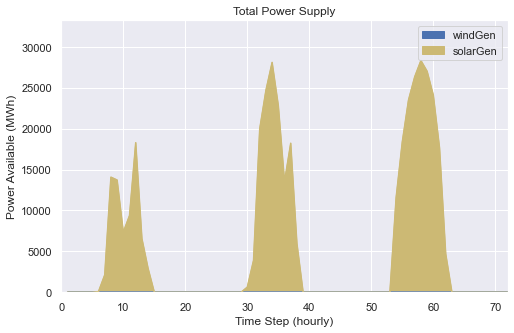

In [4]:
ax = combinedDf.plot.area(x="timestep", y=["windGen","solarGen"],#,"bsAvail"],
                style=['b','y','g'],figsize=(8, 5))
plt.title("Total Power Supply")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Power Available (MWh)")
plt.xlim([0, 72])

Text(0, 0.5, 'MWh')

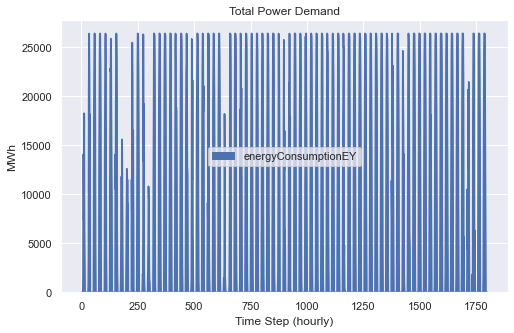

In [5]:
#now looking at energy consumption
#creating new panda columns
combinedDf["energyConsumptionEY"] = combinedDf["eyGen"]*pdEyParamDataset["energyUseEY"][0]
combinedDf["energyConsumptionBS"] = combinedDf["bsStore"]/parameterSettingsDict["bsStoreEfficiency"]
combinedDf["energyConsumptionHS"] = combinedDf["hsAvail"]*parameterSettingsDict["energyUseHS"]

combinedDf.plot.area(x="timestep", y=["energyConsumptionEY"],
                figsize=(8, 5))

plt.title("Total Power Demand")
plt.xlabel("Time Step (hourly)")
plt.ylabel("MWh")

Text(0, 0.5, 'MWh')

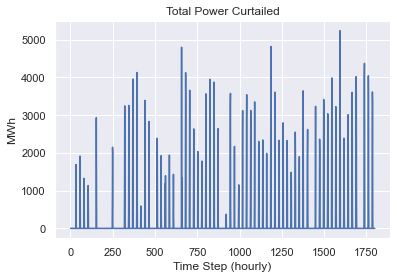

In [6]:
#looking at energy curtailed
energyCurtailedDf = combinedDf["windGen"] + combinedDf["solarGen"] + combinedDf["bsDeploy"] - combinedDf["energyConsumptionBS"] - combinedDf["energyConsumptionHS"] - combinedDf["energyConsumptionEY"]

energyCurtailedDf.plot()
plt.title("Total Power Curtailed")
plt.xlabel("Time Step (hourly)")
plt.ylabel("MWh")

Text(0, 0.5, 'Power (MWh)')

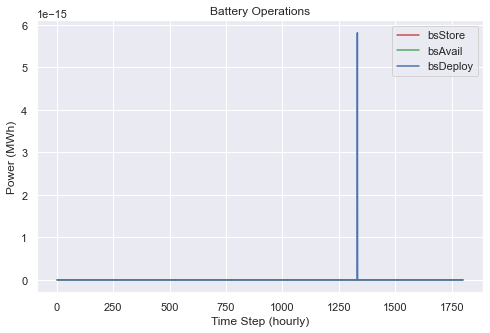

In [7]:
combinedDf.plot(x="timestep", y=["bsStore","bsAvail","bsDeploy"],
                style=['r','g','b'],figsize=(8, 5))
plt.title("Battery Operations")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Power (MWh)")

(0.0, 72.0)

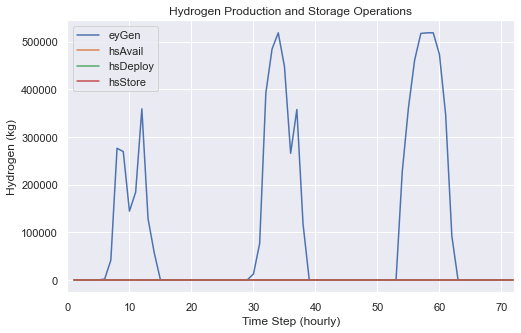

In [8]:
combinedDf.plot(x="timestep", y=["eyGen","hsAvail","hsDeploy","hsStore"],
                figsize=(8, 5))

plt.title("Hydrogen Production and Storage Operations")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Hydrogen (kg)")
plt.xlim([0, 72])

Text(0, 0.5, 'Chemical Production(kg)')

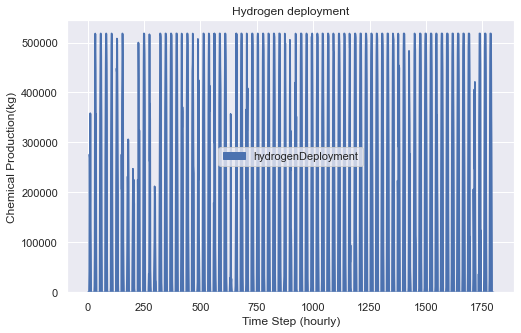

In [9]:
combinedDf.plot.area(x="timestep", y=["hydrogenDeployment"],
                figsize=(8, 5))
#generation ,"asuGen","hbGen"
plt.title("Hydrogen deployment")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Chemical Production(kg)")

Text(0.5, 1.0, 'Electroyzer Load Factor')

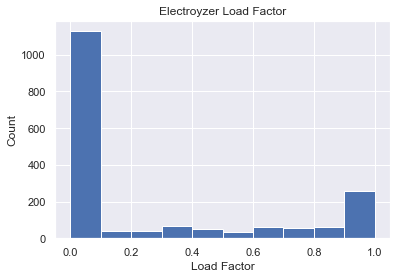

In [10]:
#looking at histogram of electroyzer operations
#NEED TO CHANGE ACCORDINGLY FOR DIFFERENT EY MODELS
loadFactor = combinedDf["eyGen"]/singleEyValueData[2][0]
loadFactor.hist()
plt.ylabel("Count")
plt.xlabel("Load Factor")
plt.title("Electroyzer Load Factor")

In [11]:
#looking at LCOE for wind and solar
windTotalGeneration = sum(cfWind["cfWind"][t]*singleValueData["windCapacity"] for t in np.arange(len(cfWind)))
solarTotalGeneration = sum(cfSolar["cfSolar"][t]*singleValueData["solarCapacity"] for t in np.arange(len(cfWind)))

totalGenTime = (8760/len(cfWind["cfWind"]))*30

print(f"Wind LCOE: {windTotalCost/(windTotalGeneration*totalGenTime)}")
print(f"Solar LCOE: {solarTotalCost/(solarTotalGeneration*totalGenTime)}")

Wind LCOE: 0   NaN
dtype: float64
Solar LCOE: 0    14.927921
dtype: float64


   windCapexCosts  windOpexCosts  solarCapexCosts  solarOpexCosts  \
0               0              0         1.728532        0.300231   

   eyCapexCosts  eyOpexCosts  hsCapexCosts  hsOpexCosts  bsCapexCosts  \
0      0.952246     0.231569             0            0             0   

   bsOpexCosts  
0            0  


Text(0, 0.5, '$/kg')

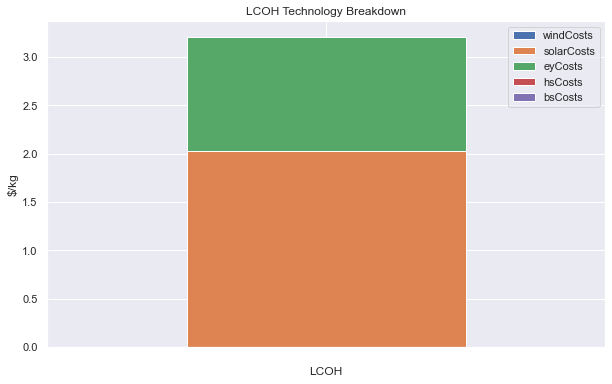

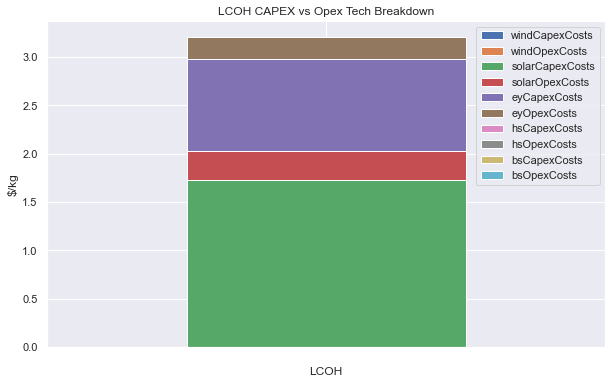

In [12]:
#now looking at LCOH costs breakdown    
costDataColNames = ["windCosts","solarCosts","eyCosts","hsCosts","bsCosts"]

dfTechCosts = singleValueData[costDataColNames]
dfTechCosts.plot.bar(stacked=True,figsize=(10, 6))
plt.title("LCOH Technology Breakdown")
plt.xticks(color="w")
plt.xlabel("LCOH")
plt.ylabel("$/kg")

'''
#checking to make sure the two cost calculations add up
for techName in ["wind","solar","ey","hs","bs","asu","hb"]:
    singleCostString = f"{techName}Costs"
    detailedCostString1 = f"{techName}CapexCosts"
    detailedCostString2 = f"{techName}OpexCosts"
    print(f"single costs {singleValueData[singleCostString][0]} = {singleValueData[detailedCostString1][0] + singleValueData[detailedCostString2][0]}")

'''

newCostDataColNames = ["windCapexCosts","windOpexCosts","solarCapexCosts","solarOpexCosts",
                                        "eyCapexCosts","eyOpexCosts","hsCapexCosts","hsOpexCosts",
                                        "bsCapexCosts", "bsOpexCosts"]
dfHighDefCosts = singleValueData[newCostDataColNames]
print(dfHighDefCosts)
dfHighDefCosts.plot.bar(stacked=True,figsize=(10, 6))
plt.title("LCOH CAPEX vs Opex Tech Breakdown")
plt.xlabel("LCOH")
plt.xticks(color="w")
plt.ylabel("$/kg")